<a href="https://colab.research.google.com/github/Sarathchandra-kvl/BERT_Classification/blob/main/BERT_email_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 30.9 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.54.0
    Uninstalling transformers-4.54.0:
      Successfully uninstalled transformers-4.54.0


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup



In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
EPOCHS=10
MAX_LEN=512
BATCH_SIZE=16

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


{}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d uciml/sms-spam-collection-dataset


Dataset URL: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset
License(s): unknown
sms-spam-collection-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip sms-spam-collection-dataset.zip


Archive:  sms-spam-collection-dataset.zip
replace spam.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
import pandas as pd

df = pd.read_csv('spam.csv', encoding='latin-1')
df = df[['v1', 'v2']]
df.columns = ['spam', 'msgs']
df['spam'] = df['spam'].apply(lambda x: 1 if x == 'spam' else 0) # Convert 'spam' and 'ham' to numerical labels
df.head()

,spam,msgs
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.shape


(5572, 2)

In [ ]:
class SMSCollectionDataset(Dataset):
    def __init__(self, spam, msgs, tokenizer, max_len):
        self.msgs = msgs
        self.spam = spam
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.msgs)

    def __getitem__(self, i):
        msg = str(self.msgs[i])
        spam = self.spam[i]

        encoding = self.tokenizer.encode_plus(
            msg,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'msg': msg,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'spam': torch.tensor(spam, dtype=torch.long)
        }

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = SMSCollectionDataset(
        spam=df['spam'].to_numpy(),
        msgs=df['msgs'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )

In [ ]:
df_train, df_test = tts(
    df,
    test_size=0.2,
    random_state=42
)
df_val, df_test = tts(
    df_test,
    test_size=0.5,
    random_state=42
)
df_train.shape, df_test.shape, df_val.shape

((4457, 2), (558, 2), (557, 2))

In [ ]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
print(len(val_data_loader))


35


In [ ]:
d = next(iter(train_data_loader))
d.keys()

d['input_ids'].shape, d['attention_mask'].shape, d['spam'].shape


(torch.Size([16, 512]), torch.Size([16, 512]), torch.Size([16]))

In [ ]:
class SpamClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SpamClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    def forward(self, input_ids, attention_mask):
        pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )[1]
        output = self.drop(pooled_output)
        return self.out(output)

In [ ]:
model = SpamClassifier(n_classes=2)
model = model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5)

total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train(
    model,
    loss_fn,
    optimizer,
    scheduler,
    device,
    data_loader,
    n_examples
):
    model = model.train() # Setting Model in training mode

    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d['input_ids'].to(device) # [16, 512]
        attention_mask = d['attention_mask'].to(device) # [16, 512]
        targets = d['spam'].to(device) # [16]

        # Forward Propogation
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        ) # [16, 3]

        # Calculating Loss
        loss = loss_fn(outputs, targets)

        _, preds = torch.max(outputs, dim=1)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        # Backward Propogation
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Clipping Gradient (Exploding Gradient Problem)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad() # Resetting gradients

    train_acc = correct_predictions.double() / n_examples
    train_loss = np.mean(losses)

    return train_acc, train_loss

In [ ]:
def evaluate_model(
    model,
    loss_fn,
    device,
    data_loader,
    n_examples
):
    model = model.eval() # Setting Model in evaluation mode

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device) # [16, 512]
            attention_mask = d['attention_mask'].to(device) # [16, 512]
            targets = d['spam'].to(device) # [16]

            # Forward Propogation
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            ) # [16, 3]

            # Calculating Loss
            loss = loss_fn(outputs, targets)

            _, preds = torch.max(outputs, dim=1)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    train_acc = correct_predictions.double() / n_examples
    train_loss = np.mean(losses)

    return train_acc, train_loss

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train(
        model,
        loss_fn,
        optimizer,
        scheduler,
        device,
        train_data_loader,
        len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = evaluate_model(
        model,
        loss_fn,
        device,
        val_data_loader,
        len(df_val)
    )

    print(f'Validation loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/10
----------


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Train loss 0.09721813862809517 accuracy 0.9685887368184878
Validation loss 0.01172883112864968 accuracy 0.9982046678635548

Epoch 2/10
----------
Train loss 0.02483191436411576 accuracy 0.9948395781916087
Validation loss 0.010790642024117655 accuracy 0.9964093357271095

Epoch 3/10
----------
Train loss 0.01175247982993374 accuracy 0.9975319721785955
Validation loss 0.011896646734385286 accuracy 0.9982046678635548

Epoch 4/10
----------
Train loss 0.001170082461469332 accuracy 0.9995512676688355
Validation loss 0.0020168673441470935 accuracy 0.9982046678635548

Epoch 5/10
----------
Train loss 0.0011382981973835208 accuracy 0.9997756338344178
Validation loss 0.007193974673334326 accuracy 0.9982046678635548

Epoch 6/10
----------
Train loss 4.0800518531616823e-05 accuracy 1.0
Validation loss 0.009467620068608084 accuracy 0.9982046678635548

Epoch 7/10
----------
Train loss 3.214583129222099e-05 accuracy 1.0
Validation loss 0.010168071810507431 accuracy 0.9982046678635548

Epoch 8/10
----

In [ ]:
test_acc, _ = evaluate_model(
    model,
    loss_fn,
    device,
    test_data_loader,
    len(df_test)
)
test_acc.item()

0.992831541218638

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

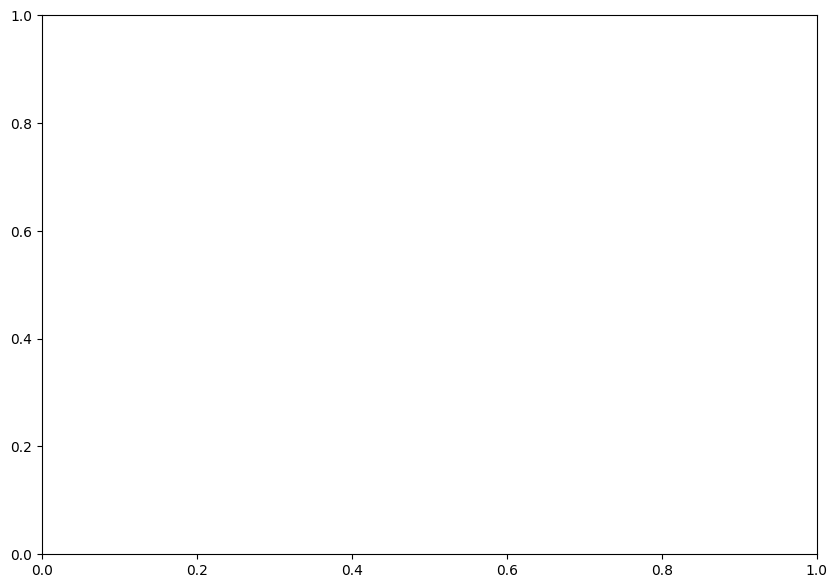

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

In [ ]:
def get_predictions(
    model, data_loader
):
    model = model.eval()

    msgs = []
    predictions = []
    predictions_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            msg = d['msg']
            input_ids = d['input_ids'].to(device)
            attention_masks = d['attention_mask'].to(device)
            spam = d['spam'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_masks
            )

            _, preds = torch.max(outputs, dim=1)

            probs = torch.nn.functional.softmax(outputs, dim=1)

            msgs.extend(msg)
            predictions.extend(preds)
            predictions_probs.extend(probs)
            real_values.extend(spam)
    predictions = torch.stack(predictions).cpu()
    predictions_probs = torch.stack(predictions_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return msgs, predictions, predictions_probs, real_values

In [ ]:
y_msgs, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)